In [1]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# TODO
- implement a full component index for model output! (maybe later though, make sure to have all dimensions indexed, is all)
- is odeint usage possible? by passing run_step as function (any_object?), instead passing array values?
- implement external initialisations for Components, like Allometric Phytoplankton


In [320]:
# This definitely also makes sense, but just as construction help for future components (and building block of the current ones)
@xs.process
class Time:
    days = xs.variable(dims='time', description='time in days')
    # for indexing xarray IO objects
    # NOTE: this is what allows storing the output along time properly even when using odeint!
    time = xs.index(dims='time', description='time in days')
    
    def initialize(self):
        self.time = self.days
        
        
        
        
@xs.process
class Component:
    """Base class encoding behaviour for a component of a ecosystem.
        subclass needs to have implemented:
        self.num, self.component_label, self.init, 
        
    """
    num = xs.variable(dims=(),intent='in')
    
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        # Note to self: sum yields1D array, due to generator unpacking within sum
        self._delta = 0.1 * dt #sum((v for v in self.fluxes))) #maybe can remove forcing to numpy array here later

    def finalize_step(self):
        self.state = self.state + self._delta * self.state
        self._delta = None

        
@xs.process
class Nutrient(Component):
    """"""
    N = xs.index(dims='N')
    component_label = xs.variable(default='N', groups='component-label', static=True)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', intent='out', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})

    # PARAMETERS / INPUTS
    num = xs.variable(default=1, static=True, description='number of nutrients (1 by default)')
    init = xs.variable(dims='N', intent='in')
    
    def initialize(self):
        self.N = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
        self.state = self.init
            
@xs.process
class Phytoplankton(Component):
    """"""
    P = xs.index(dims='P')
    component_label = xs.variable(default='P', groups='component-label', static=True)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', intent='out', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS / INPUTS
    init = xs.variable(dims='P',intent='in')
    halfsat = xs.variable(intent='in', dims='P', groups='parameters')
    
    def initialize(self):
        self.P = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
        self.state = self.init


@xs.process
class ChemostatSetup:
    P_num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    P_initVal = xs.variable(intent='in', dims=[(), 'P'], static=True, description='initial Phytoplankton biomass')
    halfsat = xs.variable(intent='in', dims=[(), 'P'], static=True, description='half-saturation constant of nutrient uptake for P')

    P_num_out = xs.foreign(Phytoplankton, 'num', intent='out')    
    P_init = xs.foreign(Phytoplankton, 'init', intent='out')
    halfsat_out = xs.foreign(Phytoplankton, 'halfsat', intent='out')
    
    N_initVal = xs.variable(intent='in', static=True, description='initial Nutrient concentration')
    N_init = xs.foreign(Nutrient, 'init', intent='out')

    
    def initialize(self):
        print('init')
        self.P_num_out = self.P_num
        self.halfsat_out = np.array([self.halfsat for i in range(self.P_num)])
        self.P_init = np.array([self.P_initVal for i in range(self.P_num)])
        self.N_init = np.array([self.N_initVal for i in range(1)])
        
        
@xs.process
class PhytoplanktonGrowth:
    """"""
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
@xs.process
class NutrientUptake(PhytoplanktonGrowth):
    """"""
    N = xs.foreign(Nutrient, 'state')
    P = xs.foreign(Phytoplankton, 'state')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat')
    
    def run_step(self):
        self.growth = self.N / (self.P_halfsat + self.N) * self.P
    
    
@xs.process
class Forcing:
    """Sum up all forcing processes and their effects, respectively.
    """
    pass
    

class NutrientSource(Forcing):
    """Chemostat constant nutrient inflow from one direction"""
    forcing_flux = xs.variable(
        dims=[(), 'N'],
        intent='out',
        groups='n_flux',
        description='constant nutrient influx'
    )

    #N = xs.foreign(Nutrient, 'state')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.forcing_flux = 0.1


In [321]:
mod = xs.Model(
    {
        'ModelSetup':ChemostatSetup,
        'N':Nutrient, 
        'P':Phytoplankton#, 
        #'N_Uptake':NutrientUptake, 
        #'N_source':NutrientSource
    }
)

In [322]:
mod

<xsimlab.Model (3 processes, 7 inputs)>
ModelSetup
    halfsat             [in] () or ('P',) half-saturation constant ...
    P_num               [in] number of Phytoplankton
    P_initVal           [in] () or ('P',) initial Phytoplankton bio...
    N_initVal           [in] initial Nutrient concentration
N
    component_label     [in]
    num                 [in] number of nutrients (1 by default)
P
    component_label     [in]

In [327]:
in_ds = xs.create_setup(
     model=mod,
     clocks={
         'time': np.linspace(0., 20., 2001)
     },
     master_clock='time',
     input_vars={
         'ModelSetup':{'P_num':5,'P_initVal':1,'halfsat':0.5, 'N_initVal':1}
     },
     output_vars={
        'P__state': 'time',
        'N__state': 'time'
     }
 )

In [328]:
with mod:
    out_ds = in_ds.xsimlab.run()

init


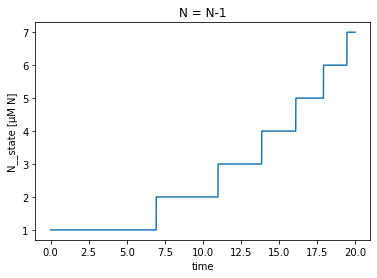

In [329]:
out_ds.N__state.plot()

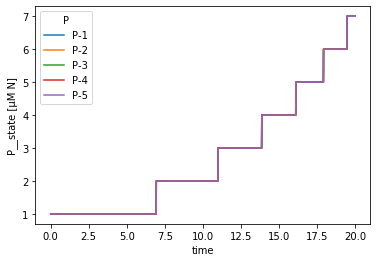

In [330]:
out_ds.P__state.set_index(P='P').plot.line(x='time')